In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

In [2]:
ser = Service('../chromedriver/chromedriver.exe')

driver = webdriver.Chrome(service = ser)

In [3]:
url = 'https://www.instagram.com/'
driver.get(url)
time.sleep(3)

In [4]:
def insta_searching(word):
    url = 'https://www.instagram.com/explore/tags/{}/'.format(word)
    return url

In [5]:
word = '제주도맛집'
url = insta_searching(word)
url

'https://www.instagram.com/explore/tags/제주도맛집/'

In [6]:
word = '제주도맛집'
url = insta_searching(word)
driver.get(url)
time.sleep(3)

In [7]:
# 지원안함
first = driver.find_element_by_css_selector('div._9AhH0')
first.click()
time.sleep(3)

C:\Users\sara\AppData\Local\Temp/ipykernel_15180/1320061655.py:2: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  first = driver.find_element_by_css_selector('div._9AhH0')


In [8]:
from selenium.webdriver.common.by import By

In [9]:
first = driver.find_element(By.CSS_SELECTOR,'div._9AhH0')
first.click()
time.sleep(3)

In [10]:
def select_first(driver):
    first = driver.find_element(By.CSS_SELECTOR,'div._9AhH0')
    first.click()
    time.sleep(3)

In [17]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [12]:
import re
import unicodedata     # 한글깨짐 개선

In [22]:
# content,  tags, like, place

#tags = soup.select('span > .xil3i')[0].text
#like = soup.select('div > a.zV_Nj > span')[0].text
#place = soup.select('div.JF9hh > a')[0].text
content = soup.select('div.C4VMK > span')[0].text

In [23]:
import re

word = '제주도맛집'
url = insta_searching(word)
driver.get(url)
time.sleep(7)

first = driver.find_element(By.CSS_SELECTOR,'div._9AhH0')
first.click()
time.sleep(5)  

html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [24]:
tags = soup.select('span > .xil3i')
tag = [ tag.text for tag in tags ]
tag

['#월정리갈비밥']

In [25]:
content = soup.select('div.C4VMK > span')[0].text
tags = re.findall(r'#[^\s,\\]+', content)
tags

['#월정리갈비밥']

In [26]:
date = soup.select('div > time')[0]['datetime'][:10]

##### 인스타크램에서 content 저장하는 함수 만들기

In [27]:
def get_content(driver):
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    try : 
        content = soup.select('div.C4VMK > span')[0].text
    except :
        content = ''
    
    try : 
        tags = re.findall(r'#[^\s,\\]+', content) 
    except :
        tags = ''
        
    date = soup.select('div > time')[0]['datetime'][:10]
    
    try :
        like = soup.select('div > a.zV_Nj > span')[0].text
    except :
        like = 0
        
    try :
        place = soup.select('div.JF9hh > a')[0].text
    except :
        place = ''
        
    data = [content, date, tags, like, place]
    
       
    return data

##### 다음페이지로 넘기는 함수 만들기

In [28]:
def move_next(driver):
    right = driver.find_element(By.CSS_SELECTOR,'div.l8mY4.feth3')
    right.click()
    time.sleep(3) 

In [29]:
move_next(driver)

In [30]:
def get_data_insta(num, driver):
    result = []
    for i in range(num):
        result.append(get_content(driver))
        move_next(driver)
    
    return result

##### insatagram crawling 하는 함수 만들기

In [31]:
def insta_crawling(word, num):
    url = insta_searching(word)
    
    driver.get(url)
    time.sleep(7)
    
    select_first(driver)
    time.sleep(3)
    
    result = []
    
    for i in range(num):
        try:
            result.append(get_content(driver))
            move_next(driver)
        except:
            time.sleep(2)
            move_next(driver)
    
    return result

In [32]:
df = pd.DataFrame(insta_crawling('제주도맛집', 10), 
                  columns = ['content', 'date', 'tags', 'like', 'place'])

##### 중복값 제거를 위한 엑셀파일 통합(교재)

In [33]:
jeju_insta_df = pd.DataFrame( [ ] )

folder = './files/'
f_list = ['1_crawling_jejudoMatJip.xlsx', '1_crawling_jejudoGwanGwang.xlsx', 
          '1_crawling_jejuMatJip.xlsx', '1_crawling_jejuYeoHang.xlsx']
for fname in f_list:
    fpath = folder + fname
    temp = pd.read_excel(fpath)
    jeju_insta_df = jeju_insta_df.append(temp)

jeju_insta_df.columns =['content','data','like','place','tags']

In [34]:
jeju_insta_df.shape

(12780, 5)

##### 중복값 제거

In [35]:
jeju_insta_df.drop_duplicates(subset=['content'], inplace = True)
jeju_insta_df.shape

(8369, 5)

In [36]:
jeju_insta_df.to_excel('./files/1_crawling_raw_class.xlsx', index = False)

###### 해시태그 데이터 가져오기

In [37]:
raw_total = jeju_insta_df.copy()

In [38]:
raw_total.columns
raw_total['tags'][:5]

0    ['#제주분식', '#제주맛집', '#제주도맛집', '#제주맛집추천', '#제주도맛...
1    ['#함덕맛집', '#제주도카페투어', '#제주일상', '#함덕', '#jejudo...
2    ['#동문시장', '#제주동문시장', '#제주도기념품', '#제주기념품', '#제주...
3    ['#제주여행', '#2일차무거버거', '#제주도여행', '#제주맛집', '#함덕맛...
4                                                   []
Name: tags, dtype: object

In [39]:
raw_total['tags'][0].str[2:-2]

0    #제주분식', '#제주맛집', '#제주도맛집', '#제주맛집추천', '#제주도맛집추...
0    #제주핫플레이스', '#제주여행', '#제주여행', '#제주도여행', '#제주가볼만...
0                                                     
0                                                 #제주도
Name: tags, dtype: object

In [40]:
tags_total = []

for tags in raw_total['tags']:
    tags_list = tags[2:-2].split("', '")
    for tag in tags_list:
        tags_total.append(tag)

In [41]:
from collections import Counter
tag_counts = Counter(tags_total)
tag_counts.most_common(50)

[('#제주맛집', 3412),
 ('#제주도맛집', 3149),
 ('#제주여행', 3020),
 ('#제주관광', 2827),
 ('#제주도', 2053),
 ('#제주', 1538),
 ('#제주도여행', 1454),
 ('#서귀포맛집', 1330),
 ('#제주도가볼만한곳', 1014),
 ('#제주핫플레이스', 835),
 ('#서귀포', 825),
 ('#jeju', 749),
 ('#일상', 701),
 ('#제주흑돼지맛집', 685),
 ('#제주맛집추천', 675),
 ('#제주도흑돼지맛집', 669),
 ('#제주도흑돼지', 663),
 ('#성산일출봉', 650),
 ('#제주흑돼지', 648),
 ('#협재맛집', 602),
 ('#제주카페', 600),
 ('#제주도그램', 594),
 ('#서귀포흑돼지맛집', 593),
 ('', 587),
 ('#서귀포흑돼지', 577),
 ('#제주도민', 570),
 ('#섭지코지', 556),
 ('#성산일출봉맛집', 545),
 ('#섭지코지맛집', 511),
 ('#선팔', 503),
 ('#제주가볼만한곳', 497),
 ('#통갈치구이', 494),
 ('#제주통갈치구이', 485),
 ('#제주핫플', 483),
 ('#제주살이', 480),
 ('#제주서귀포맛집', 479),
 ('#제주도민맛집', 477),
 ('#여행스타그램', 472),
 ('#제주반영구', 440),
 ('#제주도관광', 440),
 ('#여행', 436),
 ('#제주눈썹문신', 434),
 ('#서귀포눈썹문신', 420),
 ('#제주시', 419),
 ('#제주스타그램', 408),
 ('#눈썹문신', 405),
 ('#반영구', 405),
 ('#중문맛집', 404),
 ('#제주일상', 398),
 ('#제주속눈썹', 397)]

###### 불용어 제거

In [51]:
STOPWORDS = ['#일상', '#선팔', '#제주도', '#jeju', '#반영구', 
             '#제주자연눈썹','#서귀포눈썹문신', '#제주눈썹문신', 
             '#소통', '#맞팔','#제주일상','#제주속눈썹','#눈썹문신',
             '#제주스타그램','#여행','#제주도관광','#선팔','#제주도그램',
             '#jeju','#서귀포','#제주여행', '#제주관광', '#제주도',
             '#제주', '#제주도여행','#제주살이','#제주가볼만한곳',
             '#제주반영구','#제주시','#서귀포반영구','#서귀포속눈썹',
             '#제주남자눈썹문신', '#서귀포자연눈썹','#서귀포남자눈썹문신',
             '#카멜리아힐','#daily','#제주메이크업','#가족여행','#제주도여행코스'
             '#셀카','#제주해안도로','#제주속눈썹연장','#제주문신','#좋아요',
             '#첫줄', '#첫줄','#제주두피반영구','#서귀포문신','#제주실탄사격장',
             '#데일리','#서귀포여행','#제주도여행코스','#jejuisland','#셀카',
             '#제주공항','#제주실내관광지','#성산일출봉','#제주도민',
             '#여행스타그램','#제주반영구수강','#두피반영구','#jejudo',
             '#제주버스여행','#여행에미치다','#제주도핫플레이스','#제주도핫플',
             '#제주도가볼만한곳', '#제주핫플레이스','#섭지코지','#제주핫플',
             '#신라호텔제주','#롯데호텔제주','#제주도가족여행','#한라산',
             '#휘닉스아일랜드','#새해','#사려니숲길','#아쿠아플라넷','#단체여행'
             '#히든클리프','#협재해수욕장','#아쿠아리움','#제주도실내관광지',
             '#제주눈썹예쁜곳','#단체여행','#아쿠아플라넷제주','#히든클리프',
             '#서귀포반영구수강','#휘닉스제주','#제주커플여행','#제주관광지',
             '#휘닉스아일랜드제주', '#2019','#제주도커플여행','#제주도여행지',
             '#제주스냅','#일상스타그램','#중문가볼만한곳','#제주맘','#제주갈만한곳'
             '#단체관광', '#서귀포속눈썹파마', '#제주갈만한곳','#단체관광', '#에코랜드',
             '#제주국제대', '#만장굴', '#2박3일제주도여행','#비자림','#크리스마스','#제주도관광코스',
             '#제주도이색체험', '#제주도신혼여행','#11월제주도가볼만한곳' ]

tag_total_selected = []
for tag in tags_total :
    if tag not in STOPWORDS:
        tag_total_selected.append(tag)
        
tag_counts_selected = Counter(tag_total_selected)
tag_counts_selected.most_common(50)

[('#제주맛집', 3412),
 ('#제주도맛집', 3149),
 ('#서귀포맛집', 1330),
 ('#제주흑돼지맛집', 685),
 ('#제주맛집추천', 675),
 ('#제주도흑돼지맛집', 669),
 ('#제주도흑돼지', 663),
 ('#제주흑돼지', 648),
 ('#협재맛집', 602),
 ('#제주카페', 600),
 ('#서귀포흑돼지맛집', 593),
 ('', 587),
 ('#서귀포흑돼지', 577),
 ('#성산일출봉맛집', 545),
 ('#섭지코지맛집', 511),
 ('#통갈치구이', 494),
 ('#제주통갈치구이', 485),
 ('#제주서귀포맛집', 479),
 ('#제주도민맛집', 477),
 ('#중문맛집', 404),
 ('#먹스타그램', 395),
 ('#중문흑돼지맛집', 377),
 ('#애월맛집', 373),
 ('#성산맛집', 316),
 ('#제주시맛집', 311),
 ('#서귀포맛집추천', 303),
 ('#한림맛집', 263),
 ('#제주도카페', 258),
 ('#오설록', 241),
 ('#제주도이색맛집', 240),
 ('#제주공항근처맛집', 231),
 ('#맛집', 223),
 ('#맛스타그램', 223),
 ('#제주공항맛집', 207),
 ('#서귀포카페', 198),
 ('#제주중문맛집', 194),
 ('#제주도맛집추천', 187),
 ('#먹방', 179),
 ('#월정리맛집', 178),
 ('#중문관광단지맛집', 173),
 ('#중문맛집추천', 170),
 ('#신제주맛집', 157),
 ('#제주도성산맛집', 157),
 ('#오설록맛집', 155),
 ('#제주카페추천', 151),
 ('#제주성산맛집', 145),
 ('#이중섭거리맛집', 141),
 ('#서귀포시맛집', 133),
 ('#제주도맛집베스트', 132),
 ('#천지연폭포맛집', 130)]

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import sys

if sys.platform in ["win32","win64"]:
    font_name = 'malgun gothic'
elif sys.platform == 'darwin':
    font_name = 'AppleGothic'
    
rc('font', family = font_name)

In [52]:
tag_count_df = pd.DataFrame(tag_counts_selected.most_common(50), 
                            columns = ['tags','counts'])
tag_count_df.head()

# delete blank
tag_count_df['tags'].replace('',None, inplace = True)
tag_count_df.dropna(subset = ['tags'], inplace=True)
tag_count_df.head()

,tags,counts
0,#제주맛집,3412
1,#제주도맛집,3149
2,#서귀포맛집,1330
3,#제주흑돼지맛집,685
4,#제주맛집추천,675


<AxesSubplot:xlabel='counts', ylabel='tags'>

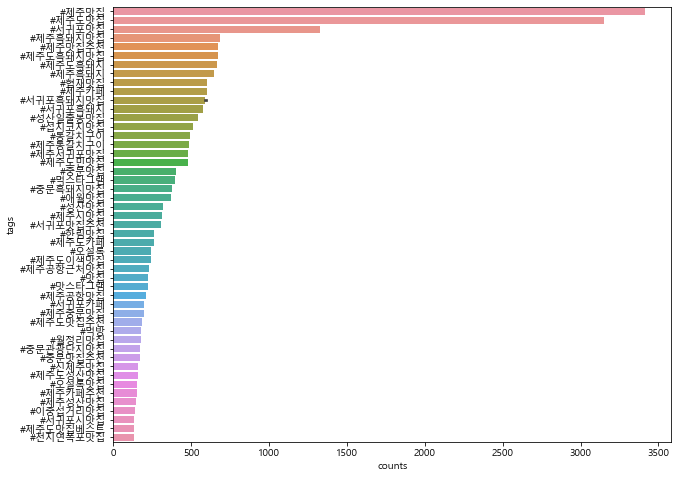

In [53]:
plt.figure(figsize = (10,8))
sns.barplot(x = 'counts',  y = 'tags', data = tag_count_df)

### 워드클라우드

##### 워드클라우드 라이브러리 불러오기

In [54]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import platform

if platform.system() == 'Windows':   #윈도우의 경우
    font_path = "c:/Windows/Fonts/malgun.ttf"
elif platform.system() == "Darwin":   #Mac 의 경우
    font_path = "/Users/$USER/Library/Fonts/AppleGothic.ttf"

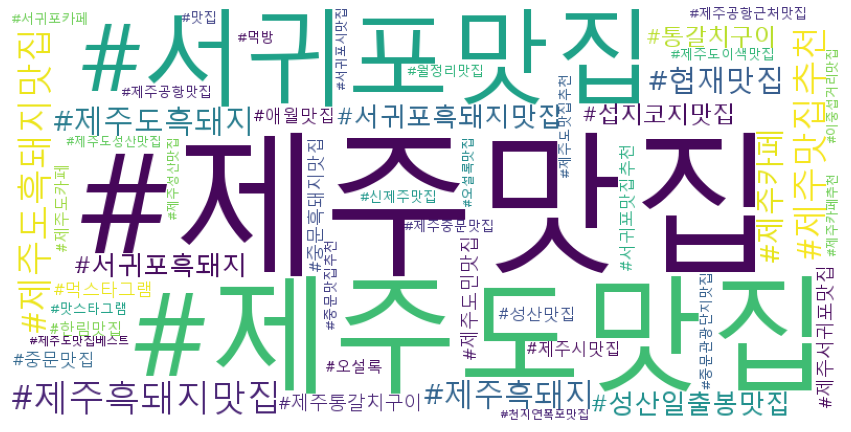

In [55]:
wordcloud = WordCloud(font_path = font_path,
                     background_color='white',
                     max_words=50,
                     relative_scaling=0.3,
                     width = 800,
                     height = 400).generate_from_frequencies(tag_counts_selected)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./files/3_2_tag-wordcloud_class.png')

### 지도 시각화

#### 데이터 준비

In [57]:
raw_total = pd.read_excel('./files/1_crawling_raw.xlsx')

In [62]:
location_counts = raw_total['place'].value_counts()
len(location_counts)

1027

In [60]:
location_counts_df = pd.DataFrame(location_counts)
location_counts_df.head()

location_counts_df.to_excel('./files/3_3_location_counts_class.xlsx')

In [61]:
locations = list(location_counts_df.index)
len(locations)

1027

##### 카카오 로컬 API 사용 예

In [63]:
import requests

In [65]:
searching = '합정 스타벅스'
url = 'http://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(searching)

headers = {
    "Authorization":"KakaoAK (Enter the API ID)"
}

places = requests.get(url, headers = headers).json()['documents']
places[0]

{'address_name': '서울 마포구 서교동 395-166',
 'category_group_code': 'CE7',
 'category_group_name': '카페',
 'category_name': '음식점 > 카페 > 커피전문점 > 스타벅스',
 'distance': '',
 'id': '26572121',
 'phone': '1522-3232',
 'place_name': '스타벅스 서교점',
 'place_url': 'http://place.map.kakao.com/26572121',
 'road_address_name': '서울 마포구 양화로 78',
 'x': '126.916980454434',
 'y': '37.5514601750423'}

In [66]:
print('place_name: ', places[0]['place_name'])
print('x : ', places[0]['x'])    # 경도
print('y : ', places[0]['y'])    # 위도

place_name:  스타벅스 서교점
x :  126.916980454434
y :  37.5514601750423


##### 카카오 로컬 API를 활용한 장소 검색 함수 만들기

In [67]:
def find_places(searching):
    # 접속 url 만들기
    url = 'http://dapi.kakao.com/v2/local/search/keyword.json?query={}'.format(searching)
    
    # headers 입력하기
    headers = {
        "Authorization":"KakaoAK (Enter the API ID)"
    }
    
    # API 요청 및 정보 받기
    places = requests.get(url, headers = headers).json()['documents']
    
    # 필요한 정보 받기
    name = places[0]['place_name']
    x = places[0]['x']    # 경도
    y = places[0]['y']    # 위도
    
    data = [name, x, y, searching]
    
    return data

In [68]:
data = find_places('제주공항')
data

['제주국제공항', '126.492769004244', '33.5070789578184', '제주공항']

##### instagram location data에 kakao api 적용하기

In [69]:
len(locations)

1027

In [70]:
from tqdm.notebook import tqdm   # 진행도 출력

In [72]:
locations_inform = []

for location in tqdm(locations[:200]):
    try :
        data = find_places(location)
        locations_inform.append(data)
        time.sleep(1)
    except:
        pass

  0%|          | 0/200 [00:00<?, ?it/s]

In [73]:
locations_inform_df = pd.DataFrame(locations_inform,
                                   columns = ['name_official', '경도', '위도', 'name'])
locations_inform_df.to_excel('./files/3_3_locations_class.xlsx', index = False)
locations_inform_df.head()

,name_official,경도,위도,name
0,Jeju in aA,126.83650369902168,33.53833652360498,Jeju
1,서귀포잠수함,126.558616052674,33.2393033784206,Seogwipo
2,바이나흐튼 크리스마스박물관,126.32785786016811,33.2915720831759,제주도 크리스마스 박물관
3,제주에인감귤밭,126.5390139270361,33.25656069063887,제주에인감귤밭
4,제주도,126.54587355630036,33.379777816446165,Jeju Island


In [74]:
location_counts_df = pd.read_excel('./files/3_location_counts.xlsx', index_col = 0)
location_inform_df = pd.read_excel('./files/3_locations.xlsx')

#print(location_counts_df.head())
location_inform_df.head()

,name_official,경도,위도,인스타위치명
0,Jeju in aA,126.836504,33.538337,Jeju
1,서귀포잠수함,126.558616,33.239303,Seogwipo
2,바이나흐튼 크리스마스박물관,126.327864,33.291569,제주도 크리스마스 박물관
3,할로비치,127.020826,37.518211,할로비치
4,제주에인감귤밭,126.539410,33.256610,제주에인감귤밭


In [75]:
location_data = pd.merge(location_inform_df,
                         location_counts_df,
                         how = 'inner',
                         left_on = 'name_official',
                         right_index = True)
location_data.head()

,name_official,경도,위도,인스타위치명,place
1,서귀포잠수함,126.558616,33.239303,Seogwipo,1
308,서귀포잠수함,126.558616,33.239303,서귀포잠수함,1
3,할로비치,127.020826,37.518211,할로비치,51
4,제주에인감귤밭,126.539410,33.256610,제주에인감귤밭,48
5,제주도,126.545876,33.379777,Jeju Island,4


##### 중복값 확인

In [77]:
location_data['name_official'].value_counts()[:5]

오설록티뮤지엄    3
서귀포잠수함     2
천지연폭포      2
빌라드아토      2
비자림        2
Name: name_official, dtype: int64

In [78]:
location_data = location_data.pivot_table(values = 'place',
                                          index = ['name_official', '경도', '위도'],
                                          aggfunc = 'sum')
location_data = location_data.sort_values(by = 'place', ascending = False)
location_data.to_excel('./files/3_location_inform_class.xlsx')
location_data.head()

,,,place
name_official,경도,위도,
할로비치,127.020826,37.518211,51
제주에인감귤밭,126.539410,33.256610,48
석부작박물관,126.536502,33.250403,36
위미동백나무군락,126.674731,33.272939,18
밥깡패,126.263436,33.410093,16


##### 지도 시각화하기

In [79]:
location_data = pd.read_excel('./files/3_location_inform.xlsx')
location_data.head()

,name_official,경도,위도,place
0,73st,126.455109,33.456989,1
1,가드망제,126.532954,33.500991,1
2,가배,126.505570,33.231541,1
3,가시식당,126.771438,33.353060,2
4,가시아방국수,126.918072,33.438605,2


In [80]:
import folium

In [81]:
Mt_Hanla = [33.352500, 126.533694]
map_jeju = folium.Map(location = Mt_Hanla, zoom_start = 10)

for i in range(len(location_data)):
    name = location_data['name_official'][i]
    count = location_data['place'][i]
    size = int(count)*2
    long = float(location_data['위도'][i])
    lat = float(location_data['경도'][i])
    folium.CircleMarker((long, lat), 
                        radius = size,
                        color = 'red',
                        popup = name).add_to(map_jeju)
map_jeju

In [82]:
map_jeju.save('./files/3_jeju_class.html')

In [83]:
Mt_Hanla = [33.352500, 126.533694]
map_jeju = folium.Map(location = Mt_Hanla, zoom_start = 11)

folium.TileLayer('CartoDB positron').add_to(map_jeju)

for i in range(len(location_data)):
    name = location_data['name_official'][i]
    count = location_data['place'][i]
    size = int(count)*2
    long = float(location_data['위도'][i])
    lat = float(location_data['경도'][i])
    folium.CircleMarker((long, lat), 
                        radius = size,
                        color = 'red',
                        popup = name).add_to(map_jeju)
map_jeju

In [84]:
from folium.plugins import MarkerCluster

In [85]:
location = []
names = []

for i in range(len(location_data)):
    data = location_data.iloc[i]
    location.append((float(data['위도']), float(data['경도'])))
    names.append(data['name_official'])
    
Mt_Hanla = [33.362500, 126.533694]
map_jeju2 = folium.Map(location = Mt_Hanla, zoom_start=10)

titles = ['stamenwatercolor', 'cartodbpositron', 
         'openstreetmap', 'stamenterrain']

for title in titles :
    folium.TileLayer(title).add_to(map_jeju2)

marker_cluster = MarkerCluster(locations = location, 
                               popups = names,
                               name = 'Jeju',
                               overlay = True,
                               control = True
                              ).add_to(map_jeju2)
folium.LayerControl().add_to(map_jeju2)

map_jeju2

In [86]:
map_jeju2.save('./files/3_jeju_cluster_class.html')

#### 특정 단어를 포함한 게시글 찾기

In [87]:
raw_total = pd.read_excel('./files/1_crawling_raw.xlsx')

In [89]:
select_word = '해돋이'

check_list = []
for content in raw_total['content']:
    if select_word in content:
        check_list.append(True)
    else :
        check_list.append(False)
        
select_df = raw_total[check_list]

In [90]:
select_df.index

Int64Index([ 878, 1552, 1626, 1994, 2109, 2420, 2726, 2753, 2828, 2862, 2929,
            3223, 5184, 5818, 5970, 6070, 6609, 6658, 6677, 6710, 6810, 6813,
            6815, 6826, 6851, 6893, 6917, 6920, 6942, 6944, 6950, 7173, 7179,
            7180, 7290, 7301, 7504, 7527, 7554, 7633, 7846, 7993, 8043, 8087,
            8151, 8153, 8218, 8254, 8321, 8325],
           dtype='int64')

In [ ]:
for i in select_df.index:
    print(select_df.loc[i, 'content'])
    print('-'*50)
select_df.head()

In [92]:
def select_list_toExcel(word_list):
    for word in word_list:
        check_list = []
        
        for content in raw_total['content']:
            if word in content:
                check_list.append(True)
            else:
                check_list.append(False)
        
        select_df = raw_total[check_list]
        fpath = f'./files/class/4_select_data_{word}.xlsx'
        select_df.to_excel(fpath)

In [93]:
select_word_list = ['해돋이', '박물관', '힐링', '게스트하우스', '섭지코지']

select_list_toExcel(select_word_list)

##### folium에 대해 알아보기

In [94]:
latitude = 37.50594228684338
longitude = 127.04967052651293
 

m = folium.Map(location = [latitude, longitude],
               width = 700,
               high = 500,
               zoom_start = 15)
    
folium.Marker(location = [latitude, longitude],
              popup = '5층',        
              tooltip = '선릉역 멀티캠퍼스',
              icon = folium.Icon(color = 'red',
                                 con_color = 'white',
                                 icon = 'wifi',
                                 prefix = 'fa')).add_to(m)

folium.CircleMarker(location = [latitude, longitude],
                   color = 'tomato',
                   radius = 50,
                   tooltip = '활동반경'
                   ).add_to(m)

m